# PubMed QA Evaluation

This notebook evaluates various large language models (LLMs) on their ability to answer yes/no/maybe medical questions from PubMed abstracts. The models are evaluated on their accuracy in understanding medical research literature and providing appropriate answers.

## Setup and Imports

First, we'll import the necessary libraries and set up the environment.

In [7]:
import pandas as pd
import numpy as np
import os
import time
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from dotenv import load_dotenv

# Try to import the OpenAI and Groq libraries
try:
    from openai import AzureOpenAI
    from groq import Groq
except ImportError:
    print("Warning: Some required libraries are missing. Install with: pip install openai groq")

# Set up display options
pd.set_option('display.max_colwidth', None)

## Load Environment Variables

Next, we'll load API keys and configurations from environment variables.

In [8]:
def load_environment():
    """Load environment variables from .env file"""
    load_dotenv()
    
    # Azure OpenAI configuration
    azure_api_key = os.getenv("AZURE_OPENAI_KEY")
    azure_api_version = os.getenv("AZURE_OPENAI_VERSION")
    azure_endpoint = os.getenv("AZURE_ENDPOINT")
    azure_deployment_name = os.getenv("AZURE_DEPLOYMENT_NAME", "gpt-4o-mini")
    
    # Groq API configuration
    groq_api_key = os.getenv("GROQ_API_KEY_MAIN")
    
    return {
        'azure_api_key': azure_api_key,
        'azure_api_version': azure_api_version,
        'azure_endpoint': azure_endpoint,
        'azure_deployment_name': azure_deployment_name,
        'groq_api_key': groq_api_key
    }

# Load environment variables
env_vars = load_environment()

# Set constants based on environment variables
AZURE_DEPLOYMENT_NAME = env_vars['azure_deployment_name']

print(f"Azure Deployment: {AZURE_DEPLOYMENT_NAME}")

Azure Deployment: gpt-4o-mini


## Initialize API Clients

Set up the clients for Azure OpenAI and Groq.

In [9]:
def init_clients(env_vars):
    """Initialize API clients"""
    clients = {}
    
    # Initialize Azure OpenAI client if credentials are available
    if all([env_vars['azure_api_key'], env_vars['azure_api_version'], env_vars['azure_endpoint']]):
        try:
            clients['azure'] = AzureOpenAI(
                api_key=env_vars['azure_api_key'],
                api_version=env_vars['azure_api_version'],
                base_url=f"{env_vars['azure_endpoint']}/openai/deployments/{env_vars['azure_deployment_name']}"
            )
            print("Azure OpenAI client initialized successfully")
        except Exception as e:
            print(f"Error initializing Azure client: {e}")
    
    # Initialize Groq client if credentials are available
    if env_vars['groq_api_key']:
        try:
            clients['groq'] = Groq(api_key=env_vars['groq_api_key'])
            print("Groq client initialized successfully")
        except Exception as e:
            print(f"Error initializing Groq client: {e}")
            
    return clients

# Initialize the API clients
clients = init_clients(env_vars)

Azure OpenAI client initialized successfully
Groq client initialized successfully
Groq client initialized successfully


## Define Models for Evaluation

Set up the models we want to evaluate.

In [10]:
# Define Groq models to evaluate
GROQ_MODELS = [
    "llama-3.3-70b-versatile",
    "mistral-saba-24b",
    "llama-3.1-8b-instant",
    "gemma2-9b-it"
]

# Build the full model list
MODELS = []

if 'azure' in clients:
    MODELS.append({"provider": "azure", "name": env_vars['azure_deployment_name']})

if 'groq' in clients:
    for model in GROQ_MODELS:
        MODELS.append({"provider": "groq", "name": model})

print(f"Models to evaluate: {len(MODELS)}")
for model in MODELS:
    print(f"- {model['provider']}: {model['name']}")

Models to evaluate: 5
- azure: gpt-4o-mini
- groq: llama-3.3-70b-versatile
- groq: mistral-saba-24b
- groq: llama-3.1-8b-instant
- groq: gemma2-9b-it


## Load and Explore Data

Load the PubMed dataset and examine its structure.

In [11]:
# Define paths
data_path = "../data/processed/pubmedqa_processed.csv"
results_dir = "../results/QA/PubMed_TorF"
plots_dir = os.path.join(results_dir, "plots")

# Create directories if they don't exist
os.makedirs(results_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

# Load the dataset
df = pd.read_csv(data_path)

# Display basic information
print(f"Dataset loaded with {len(df)} questions")
df.info()

Dataset loaded with 500 questions
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   context         500 non-null    object
 1   question        500 non-null    object
 2   options         500 non-null    object
 3   correct_option  500 non-null    object
 4   correct_answer  500 non-null    object
 5   long_answer     500 non-null    object
dtypes: object(6)
memory usage: 23.6+ KB


In [12]:
# Examine a sample from the dataset
df.sample(3)

,context,question,options,correct_option,correct_answer,long_answer
497,"['To determine whether TDP-43 type is associated with distinct patterns of brain atrophy on MRI in subjects with pathologically confirmed frontotemporal lobar degeneration (FTLD).'\n 'In this case-control study, we identified all subjects with a pathologic diagnosis of FTLD with TDP-43 immunoreactive inclusions (FTLD-TDP) and at least one volumetric head MRI scan (n = 42). In each case we applied published criteria for subclassification of FTLD-TDP into FTLD-TDP types 1-3. Voxel-based morphometry was used to compare subjects with each of the different FTLD-TDP types to age- and gender-matched normal controls (n = 30). We also assessed different pathologic and genetic variants within, and across, the different types.'\n 'Twenty-two subjects were classified as FTLD-TDP type 1, 9 as type 2, and 11 as type 3. We identified different patterns of atrophy across the types with type 1 showing frontotemporal and parietal atrophy, type 2 predominantly anterior temporal lobe atrophy, and type 3 predominantly posterior frontal atrophy. Within the FTLD-TDP type 1 group, those with a progranulin mutation had significantly more lateral temporal lobe atrophy than those without. All type 2 subjects were diagnosed with semantic dementia. Subjects with a pathologic diagnosis of FTLD with motor neuron degeneration had a similar pattern of atrophy, regardless of whether they were type 1 or type 3.']",Does TDP-43 type confer a distinct pattern of atrophy in frontotemporal lobar degeneration?,"{'A': 'yes', 'B': 'no', 'C': 'maybe'}",A,yes,"Although there are different patterns of atrophy across the different FTLD-TDP types, it appears that genetic and pathologic factors may also affect the patterns of atrophy."
472,"['To determine if composite measures based on process indicators are consistent with short-term outcome indicators in surgical colorectal cancer care.'\n 'Longitudinal analysis of consistency between composite measures based on process indicators and outcome indicators for 85 Dutch hospitals.'\n 'The Dutch Surgical Colorectal Audit database, the Netherlands.'\n '4732 elective patients with colon carcinoma and 2239 with rectum carcinoma treated in 85 hospitals were included in the analyses.'\n 'All available process indicators were aggregated into five different composite measures. The association of the different composite measures with risk-adjusted postoperative mortality and morbidity was analysed at the patient and hospital level.'\n 'At the patient level, only one of the composite measures was negatively associated with morbidity for rectum carcinoma. At the hospital level, a strong negative association was found between composite measures and hospital mortality and morbidity rates for rectum carcinoma (p<0.05), and hospital morbidity rates for colon carcinoma.']",Combining process indicators to evaluate quality of care for surgical patients with colorectal cancer: are scores consistent with short-term outcome?,"{'A': 'yes', 'B': 'no', 'C': 'maybe'}",C,maybe,"For individual patients, a high score on the composite measures based on process indicators is not associated with better short-term outcome. However, at the hospital level, a good score on the composite measures based on process indicators was consistent with more favourable risk-adjusted short-term outcome rates."
389,"['The insertion/deletion (ID) polymorphism of the angiotensin-converting enzyme (ACE) gene has been associated with increased coronary heart disease (CHD), although the mechanism of this association is not apparent. We tested the hypothesis that the deletion allele of the ACE gene is associated with insulin resistance.'\n 'We related ACE genotype to components of the insulin-resistance syndrome in 103 non-insulin-dependent diabetic (NIDDM) and 533 nondiabetic white subjects. NIDDM subjects with the DD genotype had significantly lower levels of specific insulin (DD 38.6, ID 57.1, and II 87.4

## Create Evaluation Functions

Define the functions needed for prompt creation, response processing, and model evaluation.

In [13]:
def create_prompt(context, question, options):
    """Create a prompt for the LLM models"""
    prompt = f"""Based on the following medical research context, please answer the question with ONLY 'yes', 'no', or 'maybe'. Do not provide explanations.

Context: {context}

Question: {question}

Options:
A: yes
B: no
C: maybe

Your answer (respond with only 'yes', 'no', or 'maybe'):"""
    return prompt

def process_response(response_text):
    """Extract a yes/no/maybe answer from the model response"""
    # Convert to lowercase and remove punctuation
    cleaned_text = response_text.lower().strip()
    
    # Extract yes/no/maybe from response
    if 'yes' in cleaned_text and ('no' not in cleaned_text or cleaned_text.find('yes') < cleaned_text.find('no')):
        return 'yes'
    elif 'no' in cleaned_text:
        return 'no'
    elif 'maybe' in cleaned_text:
        return 'maybe'
    else:
        # Try to find option A/B/C if direct answer not found
        if re.search(r'\b[aA]\b', cleaned_text):
            return 'yes'
        elif re.search(r'\b[bB]\b', cleaned_text):
            return 'no'
        elif re.search(r'\b[cC]\b', cleaned_text):
            return 'maybe'
        else:
            # Default to most common answer if nothing found
            return 'yes'

def get_azure_response(client, prompt, deployment_name):
    """Get a response from Azure OpenAI"""
    try:
        response = client.chat.completions.create(
            model=deployment_name,
            messages=[
                {"role": "system", "content": "You are a medical research assistant that answers questions based on medical research papers."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.0,
            max_tokens=50
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Azure API error: {e}")
        time.sleep(5)  # Wait before retrying
        return "Error"

def get_groq_response(client, model_name, prompt):
    """Get a response from Groq"""
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "You are a medical research assistant that answers questions based on medical research papers."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.0,
            max_tokens=50
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Groq API error with {model_name}: {e}")
        time.sleep(5)  # Wait before retrying
        return "Error"

In [14]:
def evaluate_model(model_info, data_df, clients, env_vars, results_dir, max_samples=None):
    """Evaluate a model on the dataset"""
    provider = model_info['provider']
    model_name = model_info['name']
    
    print(f"\nEvaluating {provider} - {model_name}...")
    
    # Limit samples if specified
    if max_samples and max_samples < len(data_df):
        eval_df = data_df.sample(max_samples, random_state=42).reset_index(drop=True)
        print(f"Using {max_samples} samples for evaluation")
    else:
        eval_df = data_df
    
    results = []
    start_time = time.time()
    
    for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df)):
        prompt = create_prompt(row['context'], row['question'], row['options'])
        
        # Get response based on provider
        if provider == 'azure':
            response_text = get_azure_response(clients['azure'], prompt, env_vars['azure_deployment_name'])
        else:  # groq
            response_text = get_groq_response(clients['groq'], model_name, prompt)
            
        if response_text == "Error":
            # Retry once more if there was an error
            time.sleep(2)
            if provider == 'azure':
                response_text = get_azure_response(clients['azure'], prompt, env_vars['azure_deployment_name'])
            else:  # groq
                response_text = get_groq_response(clients['groq'], model_name, prompt)
        
        processed_response = process_response(response_text)
        
        results.append({
            'idx': idx,
            'question': row['question'],
            'context': row['context'],
            'options': row['options'],
            'correct_answer': row['correct_answer'],
            'model_response': response_text,
            'processed_response': processed_response,
            'is_correct': processed_response == row['correct_answer']
        })
        
        # Short pause between requests to avoid rate limiting
        time.sleep(0.5)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # Calculate basic metrics
    correct_count = sum(1 for r in results if r['is_correct'])
    accuracy = correct_count / len(results)
    
    print(f"Evaluation completed in {elapsed_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f} ({correct_count}/{len(results)})")
    
    # Save results to file
    model_id = f"{provider}_{model_name.replace('-', '_')}"
    result_file = os.path.join(results_dir, f"{model_id}_results.json")
    
    with open(result_file, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"Results saved to {result_file}")
    
    return results

In [15]:
def calculate_metrics(model_results):
    """Calculate evaluation metrics from model results"""
    y_true = [item['correct_answer'] for item in model_results]
    y_pred = [item['processed_response'] for item in model_results]
    
    # Calculate accuracy
    acc = accuracy_score(y_true, y_pred)
    
    # Generate confusion matrix
    labels = ['yes', 'no', 'maybe']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Classification report
    report = classification_report(y_true, y_pred, labels=labels, output_dict=True)
    
    return {
        'accuracy': acc,
        'confusion_matrix': cm,
        'report': report,
        'labels': labels
    }

In [16]:
def plot_confusion_matrix(cm, labels, title, output_path=None):
    """Generate and save a confusion matrix visualization"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path)
        print(f"Confusion matrix saved to {output_path}")
    
    plt.show()

def plot_accuracy_comparison(metrics_dict, plots_dir=None):
    """Generate and save an accuracy comparison chart"""
    models = list(metrics_dict.keys())
    accuracies = [metrics_dict[model]['accuracy'] for model in models]
    
    # Clean model names for display
    display_names = [model.replace('_', ' ').replace('azure ', '').replace('groq ', '') for model in models]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(display_names, accuracies, color=sns.color_palette('muted', len(models)))
    
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0.0, 1.0)
    plt.xticks(rotation=45, ha='right')
    
    # Add accuracy values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', rotation=0)
    
    plt.tight_layout()
    
    if plots_dir:
        output_path = os.path.join(plots_dir, 'accuracy_comparison.png')
        plt.savefig(output_path)
        print(f"Accuracy comparison saved to {output_path}")
    
    plt.show()

## Test Single Example

Let's test a single example to make sure our prompting and response processing is working correctly.

In [17]:
# Select a random example
test_row = df.sample(1).iloc[0]

print(f"Question: {test_row['question']}")
print(f"\nContext excerpt: {str(test_row['context'])[:300]}...")
print(f"\nCorrect answer: {test_row['correct_answer']}")

# Create a prompt
test_prompt = create_prompt(test_row['context'], test_row['question'], test_row['options'])

print("\n--- Prompt ---")
print(test_prompt)

Question: Are high flow nasal cannulae noisier than bubble CPAP for preterm infants?

Context excerpt: ['Noise exposure in the neonatal intensive care unit is believed to be a risk factor for hearing loss in preterm neonates. Continuous positive airway pressure (CPAP) devices exceed recommended noise levels. High flow nasal cannulae (HFNC) are an increasingly popular alternative to CPAP for treating ...

Correct answer: no

--- Prompt ---
Based on the following medical research context, please answer the question with ONLY 'yes', 'no', or 'maybe'. Do not provide explanations.

Context: ['Noise exposure in the neonatal intensive care unit is believed to be a risk factor for hearing loss in preterm neonates. Continuous positive airway pressure (CPAP) devices exceed recommended noise levels. High flow nasal cannulae (HFNC) are an increasingly popular alternative to CPAP for treating preterm infants, but there are no in vivo studies assessing noise production by HFNC.'
 'To study whether H

In [18]:
# Test with one model if available
if 'azure' in clients:
    print("Testing with Azure OpenAI...")
    test_response = get_azure_response(clients['azure'], test_prompt, env_vars['azure_deployment_name'])
    print(f"\nRaw response: {test_response}")
    processed = process_response(test_response)
    print(f"Processed response: {processed}")
    print(f"Correct: {processed == test_row['correct_answer']}")
elif 'groq' in clients:
    print("Testing with Groq...")
    test_response = get_groq_response(clients['groq'], GROQ_MODELS[0], test_prompt)
    print(f"\nRaw response: {test_response}")
    processed = process_response(test_response)
    print(f"Processed response: {processed}")
    print(f"Correct: {processed == test_row['correct_answer']}")
else:
    print("No API clients available for testing")

Testing with Azure OpenAI...

Raw response: no
Processed response: no
Correct: True

Raw response: no
Processed response: no
Correct: True


## Run Evaluation

Now we'll run the evaluation on a sample of the dataset with all our models.

In [19]:
# Set sample size for evaluation (use a small number for testing, larger for full evaluation)
SAMPLE_SIZE = 30  # Adjust as needed

# Sample the dataset
sampled_df = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)

# Initialize storage for results
all_model_results = {}

In [20]:
# Run evaluation for each model
for model in MODELS:
    model_id = f"{model['provider']}_{model['name'].replace('-', '_')}"
    
    # Check if results already exist
    result_file = os.path.join(results_dir, f"{model_id}_results.json")
    if os.path.exists(result_file):
        print(f"Loading existing results for {model_id}")
        with open(result_file, 'r') as f:
            results = json.load(f)
    else:
        # Run evaluation for this model
        results = evaluate_model(model, sampled_df, clients, env_vars, results_dir)
    
    all_model_results[model_id] = results


Evaluating azure - gpt-4o-mini...


  0%|          | 0/30 [00:00<?, ?it/s]

Evaluation completed in 36.28 seconds
Accuracy: 0.7667 (23/30)
Results saved to ../results/QA/PubMed_TorF\azure_gpt_4o_mini_results.json

Evaluating groq - llama-3.3-70b-versatile...


  0%|          | 0/30 [00:00<?, ?it/s]

Evaluation completed in 20.45 seconds
Accuracy: 0.7667 (23/30)
Results saved to ../results/QA/PubMed_TorF\groq_llama_3.3_70b_versatile_results.json

Evaluating groq - mistral-saba-24b...


  0%|          | 0/30 [00:00<?, ?it/s]

Evaluation completed in 74.69 seconds
Accuracy: 0.6000 (18/30)
Results saved to ../results/QA/PubMed_TorF\groq_mistral_saba_24b_results.json

Evaluating groq - llama-3.1-8b-instant...


  0%|          | 0/30 [00:00<?, ?it/s]

Evaluation completed in 81.90 seconds
Accuracy: 0.8000 (24/30)
Results saved to ../results/QA/PubMed_TorF\groq_llama_3.1_8b_instant_results.json

Evaluating groq - gemma2-9b-it...


  0%|          | 0/30 [00:00<?, ?it/s]

Evaluation completed in 25.71 seconds
Accuracy: 0.5667 (17/30)
Results saved to ../results/QA/PubMed_TorF\groq_gemma2_9b_it_results.json


## Analyze Results

Let's analyze the performance of each model.

In [21]:
# Calculate metrics for each model
model_metrics = {}
for model_id, results in all_model_results.items():
    model_metrics[model_id] = calculate_metrics(results)
    
# Print accuracy summary
print("Model Accuracy Summary:")
for model_id, metrics in model_metrics.items():
    print(f"- {model_id}: {metrics['accuracy']:.4f}")

Model Accuracy Summary:
- azure_gpt_4o_mini: 0.7667
- groq_llama_3.3_70b_versatile: 0.7667
- groq_mistral_saba_24b: 0.6000
- groq_llama_3.1_8b_instant: 0.8000
- groq_gemma2_9b_it: 0.5667


Confusion matrix saved to ../results/QA/PubMed_TorF\plots\azure_gpt_4o_mini_confusion_matrix.png


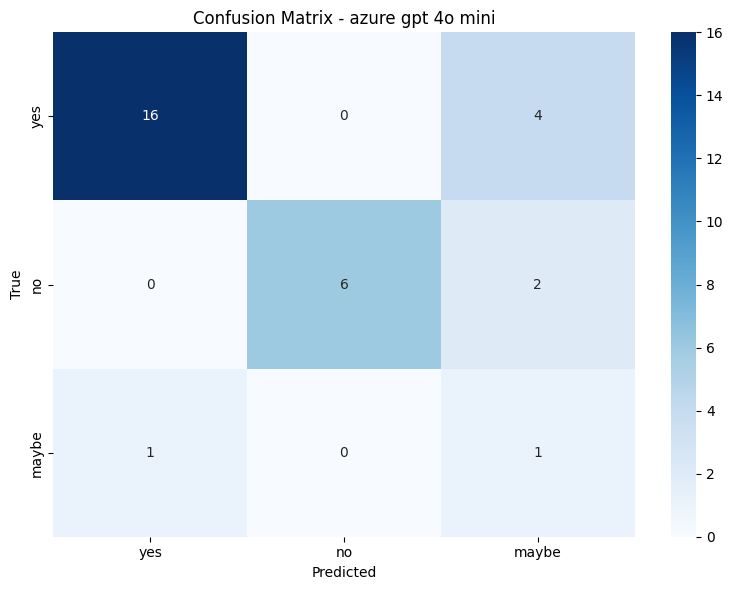

Confusion matrix saved to ../results/QA/PubMed_TorF\plots\groq_llama_3.3_70b_versatile_confusion_matrix.png


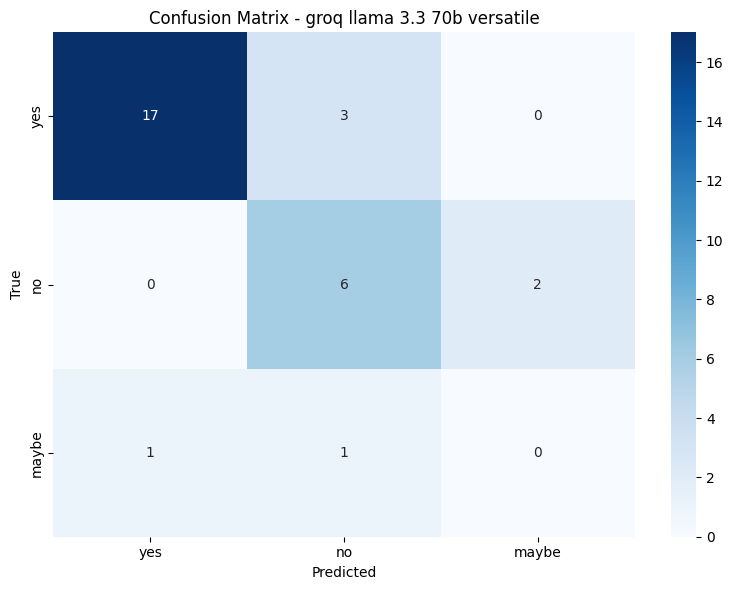

Confusion matrix saved to ../results/QA/PubMed_TorF\plots\groq_mistral_saba_24b_confusion_matrix.png


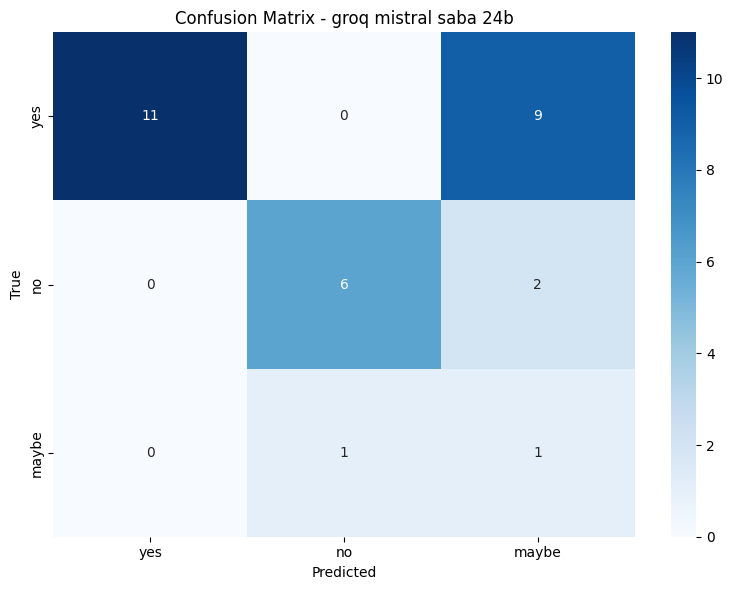

Confusion matrix saved to ../results/QA/PubMed_TorF\plots\groq_llama_3.1_8b_instant_confusion_matrix.png


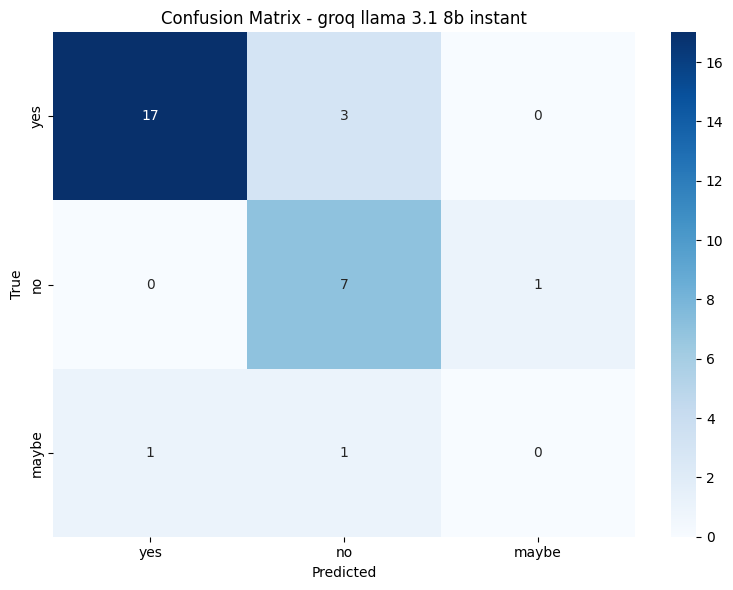

Confusion matrix saved to ../results/QA/PubMed_TorF\plots\groq_gemma2_9b_it_confusion_matrix.png


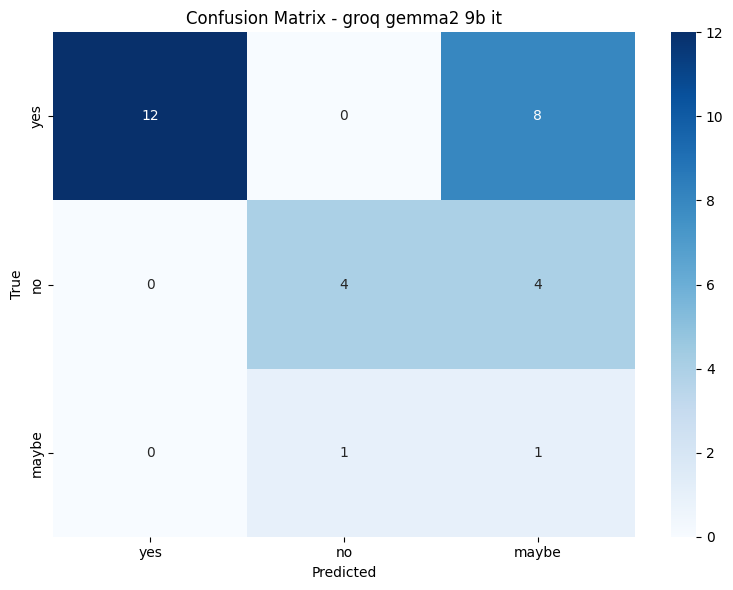

In [22]:
# Generate confusion matrices
for model_id, metrics in model_metrics.items():
    cm = metrics['confusion_matrix']
    labels = metrics['labels']
    title = f'Confusion Matrix - {model_id.replace("_", " ")}'
    output_path = os.path.join(plots_dir, f'{model_id}_confusion_matrix.png')
    plot_confusion_matrix(cm, labels, title, output_path)

Accuracy comparison saved to ../results/QA/PubMed_TorF\plots\accuracy_comparison.png


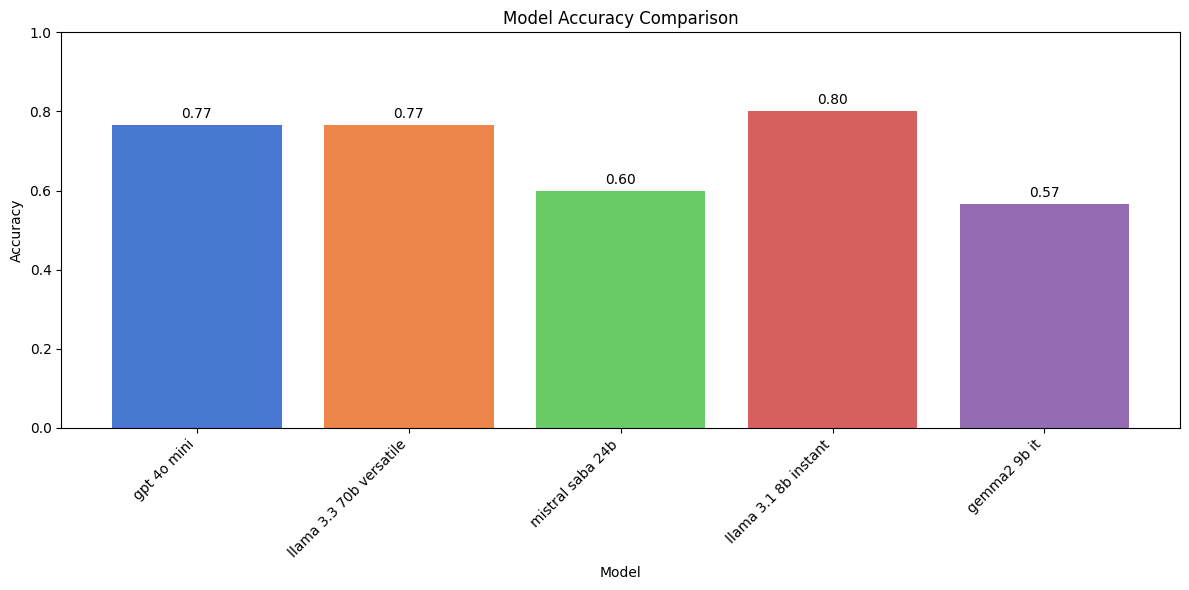

In [23]:
# Generate accuracy comparison chart
plot_accuracy_comparison(model_metrics, plots_dir)

## Detailed Performance Analysis

Let's look at detailed performance metrics by answer category and examine error patterns.

In [24]:
# Show detailed metrics for each model
for model_id, metrics in model_metrics.items():
    print(f"\n=== {model_id} ===\n")
    
    # Get the classification report
    report = metrics['report']
    
    # Create a DataFrame for better visualization
    report_df = pd.DataFrame({
        'Precision': [report[label]['precision'] for label in ['yes', 'no', 'maybe']],
        'Recall': [report[label]['recall'] for label in ['yes', 'no', 'maybe']],
        'F1-score': [report[label]['f1-score'] for label in ['yes', 'no', 'maybe']],
        'Support': [report[label]['support'] for label in ['yes', 'no', 'maybe']]
    }, index=['yes', 'no', 'maybe'])
    
    display(report_df)


=== azure_gpt_4o_mini ===



,Precision,Recall,F1-score,Support
yes,0.941176,0.80,0.864865,20.0
no,1.000000,0.75,0.857143,8.0
maybe,0.142857,0.50,0.222222,2.0



=== groq_llama_3.3_70b_versatile ===



,Precision,Recall,F1-score,Support
yes,0.944444,0.85,0.894737,20.0
no,0.600000,0.75,0.666667,8.0
maybe,0.000000,0.00,0.000000,2.0



=== groq_mistral_saba_24b ===



,Precision,Recall,F1-score,Support
yes,1.000000,0.55,0.709677,20.0
no,0.857143,0.75,0.800000,8.0
maybe,0.083333,0.50,0.142857,2.0



=== groq_llama_3.1_8b_instant ===



,Precision,Recall,F1-score,Support
yes,0.944444,0.850,0.894737,20.0
no,0.636364,0.875,0.736842,8.0
maybe,0.000000,0.000,0.000000,2.0



=== groq_gemma2_9b_it ===



,Precision,Recall,F1-score,Support
yes,1.000000,0.6,0.750000,20.0
no,0.800000,0.5,0.615385,8.0
maybe,0.076923,0.5,0.133333,2.0


In [25]:
# Analyze errors for each model
def analyze_model_errors(model_id, results):
    errors = [r for r in results if not r['is_correct']]
    print(f"\n=== Error Analysis for {model_id} ===\n")
    print(f"Total errors: {len(errors)} out of {len(results)} samples ({len(errors)/len(results):.2%})")
    
    # Error distribution by correct answer
    error_by_answer = {}
    for answer in ['yes', 'no', 'maybe']:
        answer_errors = [e for e in errors if e['correct_answer'] == answer]
        error_by_answer[answer] = len(answer_errors)
        
    print("\nError distribution by correct answer:")
    for answer, count in error_by_answer.items():
        print(f"- {answer}: {count} errors")
    
    # Show a few examples of errors
    print("\nExample errors:")
    for i, error in enumerate(errors[:3], 1):
        print(f"\nError {i}:")
        print(f"Question: {error['question']}")
        print(f"Correct Answer: {error['correct_answer']}")
        print(f"Model Answer: {error['processed_response']}")
        print(f"Raw Response: {error['model_response']}")

# Analyze errors for the first model (change index to analyze other models)
if all_model_results:
    first_model_id = list(all_model_results.keys())[0]
    analyze_model_errors(first_model_id, all_model_results[first_model_id])


=== Error Analysis for azure_gpt_4o_mini ===

Total errors: 7 out of 30 samples (23.33%)

Error distribution by correct answer:
- yes: 4 errors
- no: 2 errors
- maybe: 1 errors

Example errors:

Error 1:
Question: MiraLAX vs. Golytely: is there a significant difference in the adenoma detection rate?
Correct Answer: yes
Model Answer: maybe
Raw Response: maybe

Error 2:
Question: Does pretreatment with statins improve clinical outcome after stroke?
Correct Answer: no
Model Answer: maybe
Raw Response: maybe

Error 3:
Question: Application of computer-aided diagnosis (CAD) in MR-mammography (MRM): do we really need whole lesion time curve distribution analysis?
Correct Answer: no
Model Answer: maybe
Raw Response: maybe


## Conclusion

In this notebook, we've evaluated various LLMs on their ability to answer yes/no/maybe medical questions from PubMed abstracts. We've examined their accuracy, analyzed confusion matrices, and looked at error patterns.

Key observations:
1. The models show varying degrees of accuracy, with some performing better than others.
2. Most models struggle with 'maybe' responses, often categorizing them as definitive 'yes' or 'no' answers.
3. The context length and complexity of medical terminology present unique challenges for these models.

Future work could focus on improving prompt engineering specifically for medical contexts or fine-tuning models on medical literature.